## Symbolic Aggregate Approximation

### 1.  [reference](http://dl.acm.org/citation.cfm?id=1285965)
### 2. main usage for time series data:
1. indexing and query
2. calculating distance between time-sereis and thus perform clustering/classification
3. symbolic representation for time series - inspiring text-mining related tasks such as association mining
4. vector representation of time-series
    
### 3. algorithm steps

1. Segment time-series data into gapless pieces (e.g., gap introduced by missing values or change of sampling frequences)

2. Each piece will be SAXed into a sequence of "words" (e.g., "abcdd" "aabcd", ...). This is done by rolling a sliding window of length $window$ with a stride of length $stride$. If $stride$ < $window$, there will be overlapping of different windows. Later each window will be converted into one word

3. for each sliding window:

    3.1 whiten/normalize across the window (it is the step key to many problems)
    
    3.2 discretize on time axis (index) by grouping points into equal-sized bins (bin sizes could be fractional) - controlled by $nbins$. For each bin, use the mean of bin as local approximation.
    
    3.3 discretize on value axis by dividing values into $nlevels$ quantiles (equiprobability), for each level, calculate the "letter" by $cutpoint$ table
    
    3.4 at the end, each bin in a sliding window will be mapped to a letter, each window in the piece of time-series will be mapped to a word, and the whole piece of series will be a sentence
    
    3.5 calcualte the distance between two symoblic representations by their corresponding levels
    
    3.6 if a vector representation is necessary, each letter can be mapped to a scalar value, such as the mean of the  corresponding level.

## sax module test

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pysax
import numpy as np
reload(pysax)


<module 'pysax' from 'pysax.pyc'>

In [3]:
sax = pysax.SAXModel(window=3, stride=2) 
sax.sym2vec

{'A': -0.67, 'B': -0.335, 'C': 0.335, 'D': 0.67}

In [4]:
## test normalization
sax = pysax.SAXModel(window=3, stride=2) 
list(sax.sliding_window_index(10))
ws = np.random.random(10)
print ws.mean(), ws.std()
ss = sax.whiten(ws)
print ss.mean(), ss.std() 

0.453548930033 0.240656683904
1.33226762955e-16 0.999999999584


In [5]:
## explore binning

from fractions import Fraction
def binpack(xs, nbins):
    xs = np.asarray(xs)
    binsize = Fraction(len(xs), nbins)
    wts = [1 for _ in xrange(int(binsize))] + [binsize-int(binsize)]
    pos = 0
    while pos < len(xs):
        if wts[-1] == 0:
            n = len(wts) - 1
        else:
            n = len(wts)
        yield zip(xs[pos:(pos+n)], wts[:n])
        pos += len(wts) - 1
        rest_wts = binsize-(1-wts[-1])
        wts = [1-wts[-1]] + [1 for _ in xrange(int(rest_wts))] + [rest_wts-int(rest_wts)]
        
xs = range(0, 16)
print list(binpack(xs, 5))
xs = range(0, 16)
print list(binpack(xs, 4))
xs = range(0, 5)
print list(binpack(xs, 3))

[[(0, 1), (1, 1), (2, 1), (3, Fraction(1, 5))], [(3, Fraction(4, 5)), (4, 1), (5, 1), (6, Fraction(2, 5))], [(6, Fraction(3, 5)), (7, 1), (8, 1), (9, Fraction(3, 5))], [(9, Fraction(2, 5)), (10, 1), (11, 1), (12, Fraction(4, 5))], [(12, Fraction(1, 5)), (13, 1), (14, 1), (15, 1)]]
[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, Fraction(1, 1)), (5, 1), (6, 1), (7, 1)], [(8, Fraction(1, 1)), (9, 1), (10, 1), (11, 1)], [(12, Fraction(1, 1)), (13, 1), (14, 1), (15, 1)]]
[[(0, 1), (1, Fraction(2, 3))], [(1, Fraction(1, 3)), (2, 1), (3, Fraction(1, 3))], [(3, Fraction(2, 3)), (4, 1)]]


In [6]:
## test binning
sax = pysax.SAXModel(nbins=3) 
print list(sax.binpack(np.ones(5)))
print 
print list(sax.binpack(np.ones(9)))

[array([1.0, 0.6666666666666666], dtype=object), array([0.3333333333333333, 1.0, 0.3333333333333333], dtype=object), array([0.6666666666666666, 1.0], dtype=object)]

[array([ 1.,  1.,  1.]), array([1.0, 1.0, 1.0], dtype=object), array([1.0, 1.0, 1.0], dtype=object)]


In [7]:
## explore symbolization
import pandas as pd
cutpoints = [-np.inf, -0.43, 0.43, np.inf]
xs = np.random.random(10)
v = pd.cut(xs, bins = cutpoints, labels=["A", "B", "C"])
v

[C, B, C, B, C, B, B, C, C, B]
Categories (3, object): [A < B < C]

In [8]:
xs = np.random.randn(10)
print xs
sax = pysax.SAXModel(window=3, stride=2) 
sax.symbolize(xs)

[ 0.41548105  0.87490101 -0.06753814 -0.32386397  0.55925906  0.28783675
 -2.16330142  0.92950746 -0.3221807  -0.62561506]


[C, D, B, B, C, C, A, D, B, B]
Categories (4, object): [A < B < C < D]

In [9]:
sax = pysax.SAXModel(nbins = 5, alphabet="ABCD")
xs = np.random.randn(20) * 2 + 1.
print xs
sax.symbolize_window(xs)

[-0.1789772   0.12285898 -2.61762395  0.83527672  0.41895186  0.50320635
 -3.4516123   1.46101774  1.2087957   3.10108765  2.33038113  0.89590349
  3.54545192 -0.70599998  1.08048984 -0.91934513  1.14355207  0.35816385
  0.95483995  0.17407413]


'BBDCC'

['CCCBB', 'BCBBD', 'BABDD', 'ABDCB', 'CBBAD', 'BBBCC', 'BBDCB', 'BCBAC', 'CBADB', 'BBCBC', 'BBCCC', 'BBDBB', 'CCBBB', 'CBBBB', 'BACBD', 'ABCCD', 'ACCCC']


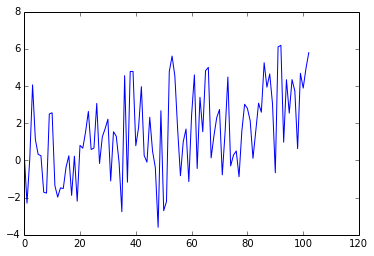

In [10]:
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
xs = np.random.randn(103) * 2 + np.arange(103) * 0.03
plt.plot(xs)
print sax.symbolize_signal(xs)

In [31]:
reload(pysax)
sax = pysax.SAXModel(window=20, stride = 20, nbins = 5, alphabet="ABCD")
xs = np.random.randn(103) * 2 + np.arange(103) * 0.03
words = sax.symbolize_signal(xs)
ts_indices = sax.convert_index(word_indices=range(len(words)))
word_indices = sax.convert_index(ts_indices = range(len(xs)))
print words
print ts_indices
print word_indices

['CBACC', 'CCCBA', 'BBCBC', 'CBDBC', 'CBCBB']
[0, 20, 40, 60, 80]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5]


In [11]:
import pysax
import numpy as np 
reload(pysax)
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
xs = np.random.randn(1000000) * 2 + np.arange(1000000) * 0.03
#plt.plot(xs)
%time psymbols = sax.symbolize_signal(xs, parallel="joblib", n_jobs=30)


save temp file at /tmp/tmptTJfOO
CPU times: user 4.19 s, sys: 279 ms, total: 4.47 s
Wall time: 35.8 s


In [12]:
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
#xs = np.random.randn(1000000) * 2 + np.arange(1000000) * 0.03
#plt.plot(xs)
%time symbols = sax.symbolize_signal(xs)
print np.all(psymbols==symbols)

CPU times: user 1min 44s, sys: 194 ms, total: 1min 44s
Wall time: 1min 44s
True


In [13]:
## test symbol to vector
%time vecs = sax.symbol_to_vector(psymbols)
vecs.shape

CPU times: user 632 ms, sys: 16.5 ms, total: 649 ms
Wall time: 643 ms


(199997, 5)

In [15]:
## test symbol distance
reload(pysax)
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
sax.symbol_distance(psymbols[0], psymbols[1]), sax.symbol_distance(psymbols[1], psymbols[2])

(1.1604740410711478, 0.67000000000000004)

In [16]:
v1, v2, v3 = sax.symbol_to_vector(psymbols[:3])

In [17]:
np.sqrt(np.sum( (v1-v2)**2 )), np.sqrt(np.sum( (v2-v3)**2 ))

(1.9818867273383716, 1.3812403845819163)

In [18]:
psymbols[:3]

['DBCAB', 'BCACC', 'BCCBB']

In [19]:
## test paa vectors
import pysax
import numpy as np 
reload(pysax)
sax = pysax.SAXModel(window=20, stride = 5, nbins = 5, alphabet="ABCD")
#xs = np.random.randn(1000000) * 2 + np.arange(1000000) * 0.03
#plt.plot(xs)
%time vecs = sax.signal_to_paa_vector(xs, n_jobs=30)

save temp file at /tmp/tmpHpHbcP
CPU times: user 4.06 s, sys: 264 ms, total: 4.33 s
Wall time: 23.5 s


In [20]:
vecs[:10, :]

array([[ 0.71871843, -0.57898006,  0.65888942, -0.73964616, -0.05898164],
       [-0.40585496,  0.63758904, -0.68649422,  0.20715821,  0.24760193],
       [-0.18031242,  0.06941735,  0.58167436, -0.20609886, -0.26468043],
       [-0.13492239,  0.20778847, -0.54273904, -0.07952303,  0.549396  ],
       [ 0.32757169, -0.86730933,  0.09914201,  0.22492647,  0.21566916],
       [-0.77452161,  0.85235836,  0.00994108, -0.02805583, -0.05972199],
       [ 1.06269128, -0.0148991 , -0.86681681, -0.35546526,  0.17448989],
       [ 0.38927352, -0.50546142,  0.19024284,  0.52367726, -0.59773219],
       [-0.35439344,  0.21470051,  0.75794055, -0.93224653,  0.31399891],
       [ 0.179947  ,  0.26568533, -0.85788735,  0.12610502,  0.28615001]])

In [21]:
psymbols[:10]

['DBCAB',
 'BCACC',
 'BCCBB',
 'BCBBC',
 'CACCC',
 'ADCBB',
 'DBABC',
 'CBCCB',
 'BCDAC',
 'CCACC']